### Import libaries

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

from keras_preprocessing.image import ImageDataGenerator

import os
import random
import shutil
import pathlib

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Prepare data

In [4]:
def distribute_train_validation_split(validation_size=0.2):

    all_images = os.listdir('train/')
    random.shuffle(all_images)

    all_dogs = list(filter(lambda image: 'dog' in image, all_images))
    all_cats = list(filter(lambda image: 'cat' in image, all_images))

    index_to_split = int(len(all_dogs) - len(all_dogs) * validation_size)
    training_dogs = all_dogs[:index_to_split]
    validation_dogs = all_dogs[index_to_split:]
    training_cats = all_cats[:index_to_split]
    validation_cats = all_cats[index_to_split:]

    shutil.rmtree('input_for_model')
    os.makedirs('input_for_model/train/dogs/', exist_ok=True)
    os.makedirs('input_for_model/train/cats/', exist_ok=True)
    os.makedirs('input_for_model/validation/dogs/', exist_ok=True)
    os.makedirs('input_for_model/validation/cats/', exist_ok=True)

    copy_images_to_dir(training_dogs, 'input_for_model/train/dogs')
    copy_images_to_dir(validation_dogs, 'input_for_model/validation/dogs')
    copy_images_to_dir(training_cats, 'input_for_model/train/cats')
    copy_images_to_dir(validation_cats, 'input_for_model/validation/cats')

def copy_images_to_dir(images_to_copy, destination):
    for image in images_to_copy:
        shutil.copyfile(f'train/{image}', f'{destination}/{image}')

distribute_train_validation_split(0.25)

In [36]:
train_imagedatagenerator = ImageDataGenerator(rescale=1/255.0)
validation_imagedatagenerator = ImageDataGenerator(rescale=1/255.0)

train_iterator = train_imagedatagenerator.flow_from_directory(
    'input_for_model/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_iterator = validation_imagedatagenerator.flow_from_directory(
    'input_for_model/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [37]:
train_iterator.next()[0].shape

(32, 150, 150, 3)

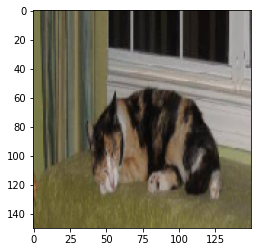

In [39]:
plt.imshow(train_iterator.next()[0][random.randint(1, 32)])
plt.show()

### Model

In [44]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [40]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [43]:
history = model.fit(train_iterator,
                    validation_data=validation_iterator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps=100)

Epoch 1/50
100/100 [==============================] - 59s 591ms/step - loss: 0.7475 - accuracy: 0.5260 - val_loss: 0.6453 - val_accuracy: 0.6403
Epoch 2/50
100/100 [==============================] - 58s 582ms/step - loss: 0.6381 - accuracy: 0.6437 - val_loss: 0.6146 - val_accuracy: 0.6697
Epoch 3/50
100/100 [==============================] - 64s 639ms/step - loss: 0.5913 - accuracy: 0.6797 - val_loss: 0.5747 - val_accuracy: 0.6947
Epoch 4/50
100/100 [==============================] - 60s 599ms/step - loss: 0.5773 - accuracy: 0.7034 - val_loss: 0.5628 - val_accuracy: 0.7022
Epoch 5/50
100/100 [==============================] - 56s 565ms/step - loss: 0.5459 - accuracy: 0.7253 - val_loss: 0.5418 - val_accuracy: 0.7106
Epoch 6/50
100/100 [==============================] - 57s 566ms/step - loss: 0.5288 - accuracy: 0.7458 - val_loss: 0.4913 - val_accuracy: 0.7556
Epoch 7/50
100/100 [==============================] - 56s 564ms/step - loss: 0.5139 - accuracy: 0.7445 - val_loss: 0.4935 - val_ac

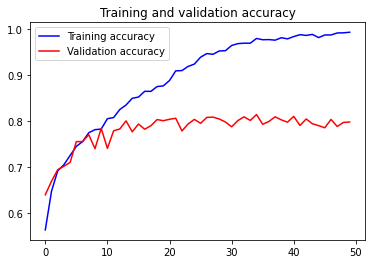

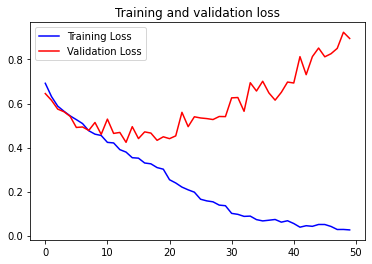

In [45]:
plot_result(history)

We've seen that we are overfitted.

We can prevent it by adding some more data or adding regularization, but I'll use Image Augmentation method just like in https://towardsdatascience.com/recognizing-cats-and-dogs-with-tensorflow-105eb56da35f this article.

#### Image augmentation

In [48]:
train_gen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)
validation_gen = ImageDataGenerator(rescale=1. / 255.0)

In [51]:
train_iterator = train_gen.flow_from_directory('input_for_model/train',
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

validation_iterator = validation_gen.flow_from_directory('input_for_model/validation',
                                                         target_size=(150, 150),
                                                         batch_size=10,
                                                         class_mode='binary')

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [52]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

In [55]:
history = model.fit(train_iterator,
                    validation_data=validation_iterator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps=100)

Epoch 1/50
100/100 [==============================] - 42s 420ms/step - loss: 0.8208 - accuracy: 0.5160 - val_loss: 0.6864 - val_accuracy: 0.6110
Epoch 2/50
100/100 [==============================] - 43s 430ms/step - loss: 0.6905 - accuracy: 0.5485 - val_loss: 0.6860 - val_accuracy: 0.5600
Epoch 3/50
100/100 [==============================] - 45s 445ms/step - loss: 0.6861 - accuracy: 0.5307 - val_loss: 0.6529 - val_accuracy: 0.5950
Epoch 4/50
100/100 [==============================] - 44s 436ms/step - loss: 0.6827 - accuracy: 0.5891 - val_loss: 0.6263 - val_accuracy: 0.6140
Epoch 5/50
100/100 [==============================] - 40s 401ms/step - loss: 0.6784 - accuracy: 0.5609 - val_loss: 0.6237 - val_accuracy: 0.6630
Epoch 6/50
100/100 [==============================] - 34s 341ms/step - loss: 0.6525 - accuracy: 0.6140 - val_loss: 0.6382 - val_accuracy: 0.6450
Epoch 7/50
100/100 [==============================] - 36s 359ms/step - loss: 0.6407 - accuracy: 0.6204 - val_loss: 0.6349 - val_ac

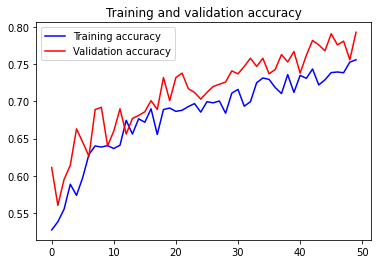

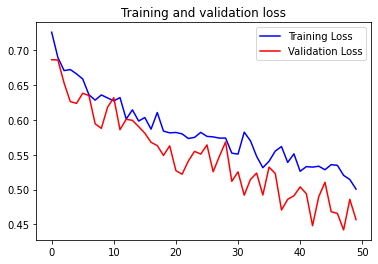

In [56]:
plot_result(history)

Now we preferent overfitting, but our accuracy is no more than 75%(basic model). I think if we increase batch size for a little we might have another results.

In [57]:
train_iterator = train_gen.flow_from_directory('input_for_model/train',
                                                   target_size=(150, 150),
                                                   batch_size=64,
                                                   class_mode='binary')

validation_iterator = validation_gen.flow_from_directory('input_for_model/validation',
                                                         target_size=(150, 150),
                                                         batch_size=32,
                                                         class_mode='binary')

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [58]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)            

In [61]:
history = model.fit(train_iterator,
                    validation_data=validation_iterator,
                    steps_per_epoch=200,
                    epochs=50,
                    validation_steps=100)

Epoch 1/50
200/200 [==============================] - 224s 1s/step - loss: 0.8391 - accuracy: 0.5289 - val_loss: 0.6776 - val_accuracy: 0.5741
Epoch 2/50
200/200 [==============================] - 197s 985ms/step - loss: 0.6810 - accuracy: 0.5647 - val_loss: 0.6444 - val_accuracy: 0.6125
Epoch 3/50
200/200 [==============================] - 196s 979ms/step - loss: 0.6336 - accuracy: 0.6281 - val_loss: 0.5901 - val_accuracy: 0.6803
Epoch 4/50
200/200 [==============================] - 212s 1s/step - loss: 0.5874 - accuracy: 0.6856 - val_loss: 0.6393 - val_accuracy: 0.6481
Epoch 5/50
200/200 [==============================] - 221s 1s/step - loss: 0.5784 - accuracy: 0.6965 - val_loss: 0.5094 - val_accuracy: 0.7509
Epoch 6/50
200/200 [==============================] - 218s 1s/step - loss: 0.5528 - accuracy: 0.7136 - val_loss: 0.4903 - val_accuracy: 0.7688
Epoch 7/50
200/200 [==============================] - 212s 1s/step - loss: 0.5318 - accuracy: 0.7344 - val_loss: 0.4754 - val_accuracy: 

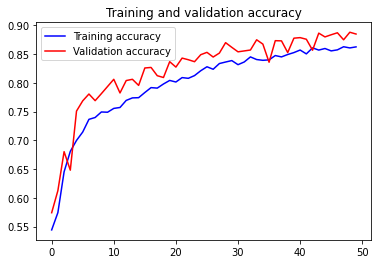

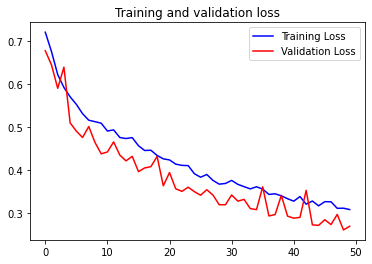

In [62]:
plot_result(history)

Now we get accuracy more than 80%